# Gavin Kendal-Freedman

## Research question/interests

**My main interest is how different chemicals effect air quality ratings, specifically the main hazardous components in fuels for motor vehicles or stoves like natural gas/gasoline/diesel fuels (benzene, toluene, propane, methane, sulfurs/oxides of nitrogens, 2,2,4-Trimethylpentane (octane from standard gasoline)), and also potentially common organic solvents/reagents that are used in manufacturing (methacrylates, chloroform/methyl chloroform, acetylene, nitric acid), and how these different particulates effect AQI. Further, I want to see if there is a significant difference in air quality change across time in urban vs rural areas (not just if urban areas have better/worse air quality), based on specific particulates in the first part, and if there is any correlations between asthma rates in different areas and the levels of pollutants there (not across time because the asthma data does not have a time series attached to it).**

### Rough Plan for Data Analysis

1. (Already done as part of loading) Combine all EPA data files into one dataframe
1. Remove all rows that do not contain the parameters of interest (see above)
1. Remove columns that are mostly null/na/nan/missing values or are not interesting to the analysis
1. For locations that have multiple observations for a parameter in a year, average them and all statistics about the measurements for the year
1. Isolate a single metric for each parameter of interest (preferably "Observed Values"), preferably an overall average for the year and not the mean for daily maximums
1. Check for any correlations between the parameters of interest to other parameters of interest, and the AQI
1. Check changes in concentrations over time and see if there are any correlations between the changes in concentrations and the AQI
1. Geo-plot the change in AQI over time for each location, with an overlay showing the change in a normalization and aggregation of the parameters of interest
1. For 2020, geo-plot the AQI and the parameters of interest for each location and overlay the asthma rates for each location

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

In [ ]:
# Setup seaborn/matplotlib theme information
sns.set_theme(style="darkgrid", font_scale=1.5) # type: ignore
shapedata: gpd.GeoDataFrame = gpd.read_file(gplt.datasets.get_path("contiguous_usa"))

In [ ]:
# Load the Data
# First, lets open and concatenate every years AQI data here using a generator to read each, since the names are programmatic
aqi = pd.concat(
    (pd.read_csv(f"../data/raw/annual_aqi_by_cbsa_{x}.csv") for x in range(2011, 2023))
)
# Second, lets open and concatenate all the concentration data from each year in a similar vein to the AQI data
concentration = pd.concat(
    (
        pd.read_csv(f"../data/raw/annual_conc_by_monitor_{x}.csv")
        for x in range(2011, 2023)
    )
)
# Now, lets merge the two data frames together on the YEAR and CBSA (Name) columns using an inner join
# Inner Join/Merge only joins rows that have matching data for the YEAR and CBSA (Name) columns in both the left and right dataframe
# CBSA is a location identifier (Core Based Statistical Areas) - more info on them can be found here:
#   https://aqs.epa.gov/aqsweb/documents/codetables/cbsas.html
combined = concentration.merge(
    aqi, how="inner", left_on=["Year", "CBSA Name"], right_on=["Year", "CBSA"]
).drop(columns=["CBSA"])
# Now, lets "print" the first 5 rows to make sure that it joined as expected
combined = gpd.GeoDataFrame(combined, geometry=gpd.points_from_xy(combined.Longitude, combined.Latitude))  # type: ignore
# print(combined.columns)
combined.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,geometry
0,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,1 HOUR,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)
1,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)
2,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)
3,1,3,10,44201,1,30.497478,-87.880258,NAD83,Ozone,8-HR RUN AVG BEGIN HOUR,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)
4,1,3,10,68101,1,30.497478,-87.880258,NAD83,Sample Flow Rate- CV,24 HOUR,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)


In [ ]:
filtered = combined.drop(
    combined.index[
        (combined["State Code"].isin({2, 15, 72}))
        # | (~combined["Parameter Name"].isin(whitelist))
        | (combined["Arithmetic Mean"].isna())
        | (combined["Observation Count"] < combined["Required Day Count"])
    ]
).drop(
    columns=[
        "State Code",
        "County Code",
        "Local Site Name",
        "Address",
        "Latitude",
        "Longitude",
        "Datum",
        "1st Max Non Overlapping Value",
        "1st NO Max DateTime",
        "2nd Max Non Overlapping Value",
        "2nd NO Max DateTime",
        "Date of Last Change",
        "Sample Duration",
        "Site Num",
        "Pollutant Standard",
        "CBSA Code",
        "Certification Indicator",
        "Completeness Indicator",
        "Parameter Code",
        "1st Max DateTime",
        "1st Max Value",
        "2nd Max DateTime",
        "2nd Max Value",
        "3rd Max DateTime",
        "3rd Max Value",
        "4th Max DateTime",
        "4th Max Value",
        "Method Name",
    ]
).reset_index()
filtered.head()

,index,POC,Parameter Name,Metric Used,Year,Units of Measure,Event Type,Observation Count,Observation Percent,Valid Day Count,...,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,geometry
0,0,1,Ozone,Daily maxima of observed hourly values (betwee...,2011,Parts per million,No Events,5609,100,245,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)
1,1,1,Ozone,Daily maximum of 8 hour running average of obs...,2011,Parts per million,No Events,5864,100,245,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)
2,2,1,Ozone,Daily maximum of 8 hour running average of obs...,2011,Parts per million,No Events,5864,100,245,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)
3,3,1,Ozone,Daily maximum of 8-hour running average,2011,Parts per million,No Events,4149,99,242,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)
4,4,1,Sample Flow Rate- CV,Observed Values,2011,Percent,No Events,115,100,58,...,0,126,74,42,0,0,209,73,0,POINT (-87.88026 30.49748)


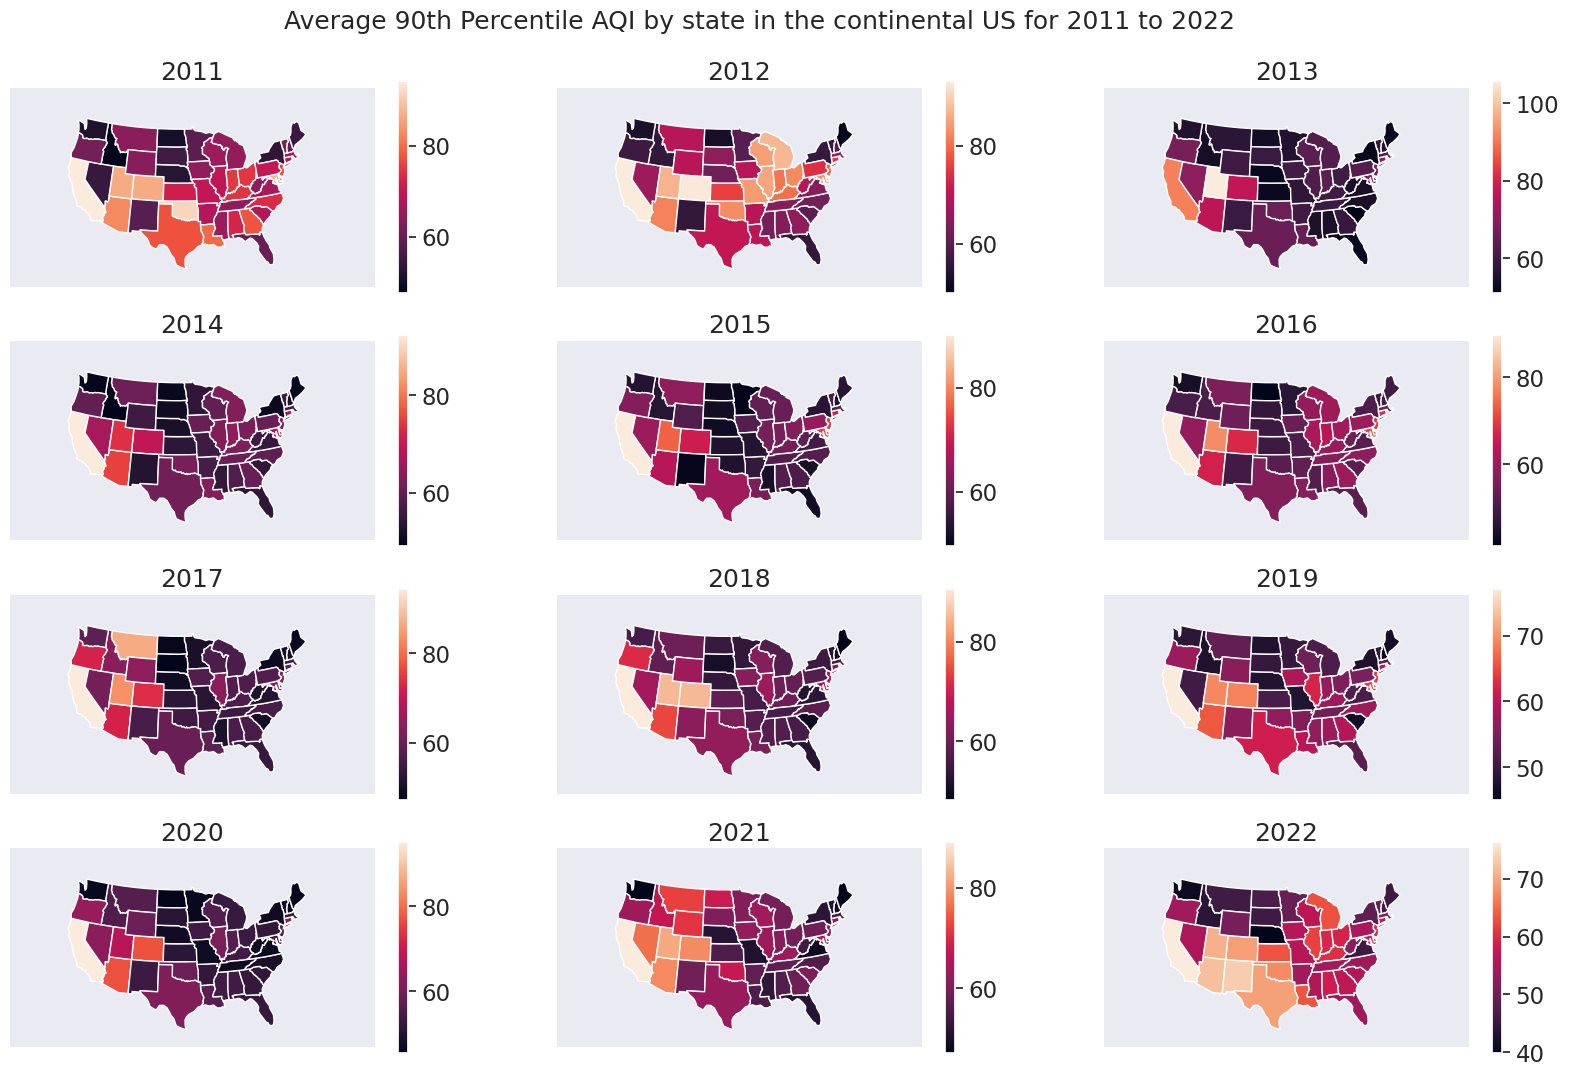

In [ ]:
averaged = shapedata.merge(
    filtered[(filtered["90th Percentile AQI"] >= 0) & (filtered["90th Percentile AQI"] <= 500)]
    .drop_duplicates(subset=["CBSA Name", "Year"])
    .groupby(["Year", "State Name"])["90th Percentile AQI"]
    .mean()
    .reset_index(),
    left_on="state",
    right_on="State Name",
)

projection = gcrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795)

fig, axarr = plt.subplots(4, 3, figsize=(20, 12), subplot_kw={"projection": projection}, sharex=True, sharey=True)

minAqi = max(0, (averaged["90th Percentile AQI"].min() // 50) * 50)
maxAqi = min(500, ((averaged["90th Percentile AQI"].max() + 50) // 50) * 50)
legend_values = list(map(str, range(int(minAqi), int(maxAqi+1), 50)))

year_mapping_info: dict[int, tuple[int, int]] = {
    2011: (0, 0),
    2012: (0, 1),
    2013: (0, 2),
    2014: (1, 0),
    2015: (1, 1),
    2016: (1, 2),
    2017: (2, 0),
    2018: (2, 1),
    2019: (2, 2),
    2020: (3, 0),
    2021: (3, 1),
    2022: (3, 2),
}
for year in averaged.Year.unique():
    # if year == 2022:
    #     continue
    ax = axarr[year_mapping_info[year][0]][year_mapping_info[year][1]]
    gplt.choropleth(
        averaged[((averaged["Year"] == year))],
        hue="90th Percentile AQI",
        ax=ax,
        legend=True,
        # legend_labels=legend_values
    )
    ax.set_title(f"{year}", fontsize=18)
plt.subplots_adjust(top=0.92)
title = plt.suptitle(
    "Average 90th Percentile AQI by state in the continental US for 2011 to 2022",
    fontsize=18,
)


In [ ]:
whitelist = [
    "1,2,4-Trimethylbenzene",
    "1,3-Butadiene",
    # "1-Methylnapthalene",
    # "1-butene", # Not in dataset
    "2,2,4-Trimethylpentane",
    "2-Methylheptane",
    "3-Methylheptane",
    "Benzene",
    "Carbon disulfide",
    "Carbon monoxide",
    "Cyclopentane",
    "Ethane",
    "Ethylbenzene",
    "Ethylene dibromide",
    "Ethylene dichloride",
    "Furan, tetrahydro-",
    # "Heptane",
    # "Hexachlorobutadiene",
    "Hydrogen sulfide",
    "Isobutane",
    # "Isobutene",
    # "Isobutene & 1-butene",
    "Isopentane",
    "Isoprene",
    "Isopropylbenzene",
    "Methane",
    # "Methanethiol", # Not in dataset
    # "Methanol",
    # "Methyl mercaptan", # Not in Dataset
    "Methyl tert-butyl ether",
    "NOy - NO",
    # "Naphthalene",
    "Nitric oxide (NO)",
    "Nitrogen dioxide (NO2)",
    "Oxides of nitrogen (NOx)",
    "Propane",
    "Propylene",
    # "Reactive oxides of nitrogen (NOy)",
    "Sulfur dioxide",
    "Tert-amyl methyl ether",
    "Toluene",
    # "Total reduced sulfur",
    # "Xylene(s)",
    "cis-2-Butene",
    # "m-Xylene",
    "m/p Xylene",
    "n-Butane",
    "n-Decane",
    "n-Dodecane",
    "n-Heptane",
    "n-Hexane",
    "n-Nonane",
    "n-Octane",
    "n-Pentane",
    # "n-Tridecane",
    "n-Undecane",
    "o-Xylene",
    # "p-Xylene",
    "tert-Butyl ethyl ether",
    "trans-2-Butene",
]

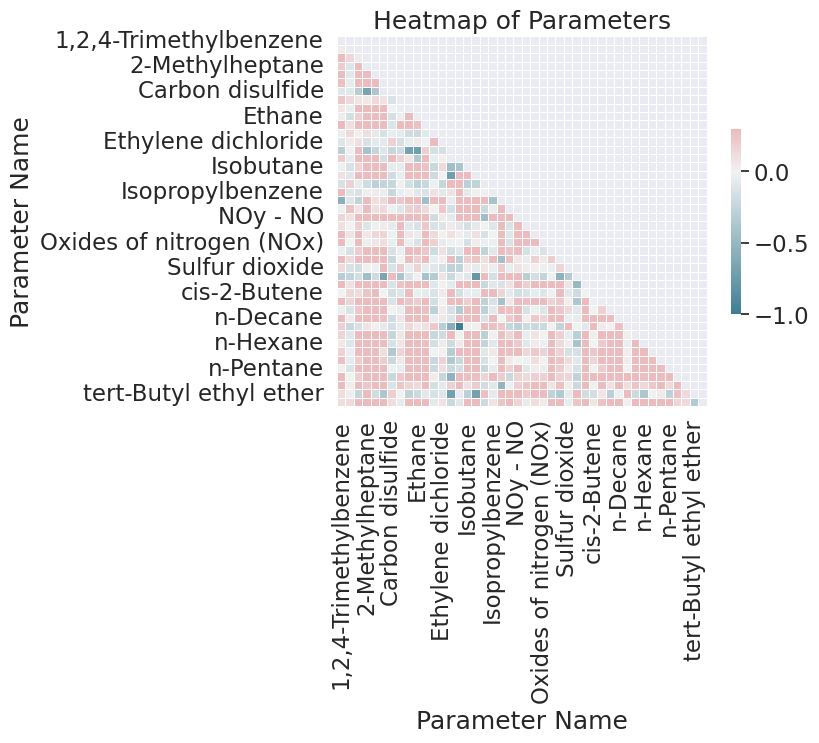

In [ ]:
grouped = (
    filtered.drop(filtered.index[~filtered["Parameter Name"].isin(whitelist)])
    .drop_duplicates(subset=["CBSA Name", "Year", "Parameter Name"])
    .groupby(["CBSA Name", "Parameter Name"], as_index=False)
)["Arithmetic Mean"].agg("mean").pivot(
    values="Arithmetic Mean",
    columns="Parameter Name",
    index="CBSA Name",
)
corr = grouped.corr()

# Generate a mask for the top right so we only generate one correlation per 
# pair of factors.
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Generate custom color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create figure using seaborn:
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap.set(title='Heatmap of Parameters')
None

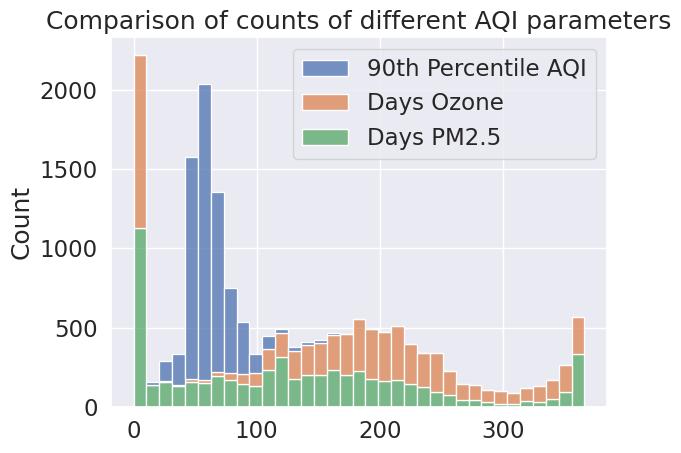

In [ ]:
histplot = sns.histplot(filtered.drop_duplicates(["Year", "CBSA Name"]).reset_index()[["90th Percentile AQI", "Days Ozone", "Days PM2.5"]], multiple="stack")
histplot.set(title="Comparison of counts of different AQI parameters")
None